<a href="https://colab.research.google.com/github/olya-ds/practical-work/blob/main/automated_logging_of_meetings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="top"></a>
# Научно-исследовательская работа
**Тема:** Разработка алгоритма для автоматизированного протоколирования собраний

**Выполнила:** Медведева Ольга

**Содержание:**
* [Конвертация из mp4 в wav](#mp4_to_wav)
* [Сегментация звука](#seg_sound)
* [Диаризация речи](#dir_and_viz)
* [Детекция голосовой активности](#vad)
* [Распознавание речи](#speech_to_text)
* [Извлечение именнованных сущностей](#entity)
* [Оценка качества](#quality)

## Блок импортов
[К началу](#top)

In [1]:
! pip install -q https://github.com/pyannote/pyannote-audio/archive/develop.zip
! pip install -q speechbrain
! pip install -q pydub
! pip install -q SpeechRecognition
! pip install -q jiwer
! pip install -q stanza
! pip install -q pullenti-wrapper

!git clone https://github.com/speechbrain/speechbrain.git

     |████████████████████████████████| 13.6 MB 1.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 101 kB 6.1 MB/s 
     |████████████████████████████████| 79 kB 2.2 MB/s 
     |████████████████████████████████| 65 kB 5.4 MB/s 
     |████████████████████████████████| 41 kB 664 kB/s 
     |████████████████████████████████| 51 kB 252 kB/s 
     |████████████████████████████████| 585 kB 44.8 MB/s 
     |████████████████████████████████| 110 kB 76.6 MB/s 
     |████████████████████████████████| 419 kB 66.4 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
     |████████████████████████████████| 117 kB 68.4 MB/s 
     |████████████████████████████████| 596 kB 58.2 MB/s 
     |████████████████████████████████| 130 kB 73.7 MB/s 
     |████████████████████████████████| 308 kB 68.2 MB/s 
     |████████████████████████████████| 209 kB 80.4 MB/s 
     |█████████

In [2]:
cd speechbrain

/content/speechbrain


In [3]:
!pip install -r requirements.txt
!pip install -e

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Ignoring SoundFile: markers 'sys_platform == "win32"' don't match your environment
     |████████████████████████████████| 97 kB 4.1 MB/s 
     |████████████████████████████████| 97 kB 7.7 MB/s 
     |████████████████████████████████| 69 kB 11.0 MB/s 
     |████████████████████████████████| 51 kB 9.7 MB/s 
     |████████████████████████████████| 246 kB 60.7 MB/s 
     |████████████████████████████████| 58 kB 8.6 MB/s 
     |████████████████████████████████| 86 kB 296 kB/s 
     |████████████████████████████████| 199 kB 74.9 MB/s 
     |████████████████████████████████| 843 kB 77.5 MB/s 
     |████████████████████████████████| 59 kB 10.8 MB/s 
     |████████████████████████████████| 98 kB 12.0 MB/s 
     |████████████████████████████████| 10.1 MB 58.8 MB/s 
     |████████████████████████████████| 461 kB 50.8 MB/s 
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1

In [4]:
cd recipes/VoxCeleb/SpeakerRec

/content/speechbrain/recipes/VoxCeleb/SpeakerRec


In [5]:
! python train_speaker_embeddings.py hparams/train_ecapa_tdnn.yaml --data_folder=your_data_folder

rirs_noises.zip: 1.31GB [00:49, 26.6MB/s]                
Extracting your_data_folder/rirs_noises.zip to your_data_folder
your_data_folder/rirs_noises.zip exists. Skipping download
your_data_folder/rirs_noises.zip exists. Skipping download
veri_test2.txt: 2.33MB [00:01, 1.82MB/s]               
Getting file list...
0it [00:00, ?it/s]
0it [00:00, ?it/s]
Traceback (most recent call last):
  File "train_speaker_embeddings.py", line 233, in <module>
    train_data, valid_data, label_encoder = dataio_prep(hparams)
  File "train_speaker_embeddings.py", line 139, in dataio_prep
    replacements={"data_root": data_folder},
  File "/usr/local/lib/python3.7/dist-packages/speechbrain/dataio/dataset.py", line 366, in from_csv
    return cls(data, dynamic_items, output_keys)
  File "/usr/local/lib/python3.7/dist-packages/speechbrain/dataio/dataset.py", line 151, in __init__
    static_keys = list(self.data[self.data_ids[0]].keys())
IndexError: list index out of range




---



In [1]:
from pyannote.audio import Inference
from pyannote.audio import Pipeline
from pyannote.audio import Model
from pyannote.core import Annotation, notebook, Segment
import torchaudio
import torch

from pydub import AudioSegment
import IPython

import speech_recognition as sr
from jiwer import compute_measures
import re
import pandas as pd

import stanza
from pullenti_wrapper.processor import (
    Processor,
    MONEY,
    URI,
    PHONE,
    DATE,
    KEYWORD,
    DEFINITION,
    DENOMINATION,
    MEASURE,
    BANK,
    GEO,
    ADDRESS,
    ORGANIZATION,
    PERSON,
    MAIL,
    TRANSPORT,
    DECREE,
    INSTRUMENT,
    TITLEPAGE,
    BOOKLINK,
    BUSINESS,
    NAMEDENTITY,
    WEAPON,
)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name="mp4_to_wav"></a>
## Конвертация из mp4 в wav
[К началу](#top)

In [39]:
# конвертирую видео в аудио (wav-формат) и сохраняю файл

def mp4_to_wav(open_file, save_file):

    sound = AudioSegment.from_file(open_file, "mp4").export (save_file, format ="wav")

    return sound.name

In [40]:
path = '/content/drive/MyDrive/Practical_work/'
open_file = path+'/ITMO_ENTER.mp4'
save_file = path+'/ITMO_ENTER.wav'

In [42]:
# вывожу аудио

IPython.display.display(IPython.display.Audio(mp4_to_wav(open_file, save_file)))

<a name="seg_sound"></a>
## Сегментация звука
[К началу](#top)

Загрузка модели сегментации динамиков

In [5]:
model = Model.from_pretrained("pyannote/segmentation")
model.summarize()

Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

  | Name       | Type       | Params | In sizes      | Out sizes                                  
--------------------------------------------------------------------------------------------------------
0 | sincnet    | SincNet    | 42.6 K | [3, 1, 32000] | [3, 60, 115]                               
1 | lstm       | LSTM       | 1.4 M  | [3, 115, 60]  | [[3, 115, 256], [[8, 3, 128], [8, 3, 128]]]
2 | linear     | ModuleList | 49.4 K | ?             | ?                                          
3 | classifier | Linear     | 516    | [3, 115, 128] | [3, 115, 4]                                
4 | activation | Sigmoid    | 0      | [3, 115, 4]   | [3, 115, 4]                                
--------------------------------------------------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.892     Total estimated model params size (MB)

Технические характеристики модели

In [6]:
specs = model.specifications
specs

Specifications(problem=<Problem.MULTI_LABEL_CLASSIFICATION: 2>, resolution=<Resolution.FRAME: 1>, duration=5.0, warm_up=(0.0, 0.0), classes=['speaker#1', 'speaker#2', 'speaker#3', 'speaker#4'], permutation_invariant=True)

* `duration = 5.0`: модель воспринимает звуковые фрагменты длиной 5 секунд
* `Resolution.FRAME` и `len(classes) == 4`: модель выводит последовательность 4-мерных оценок по кадрам
* `Problem.MULTI_LABEL_CLASSIFICATION` для каждого кадра одновременно может быть активировано более одного динамика


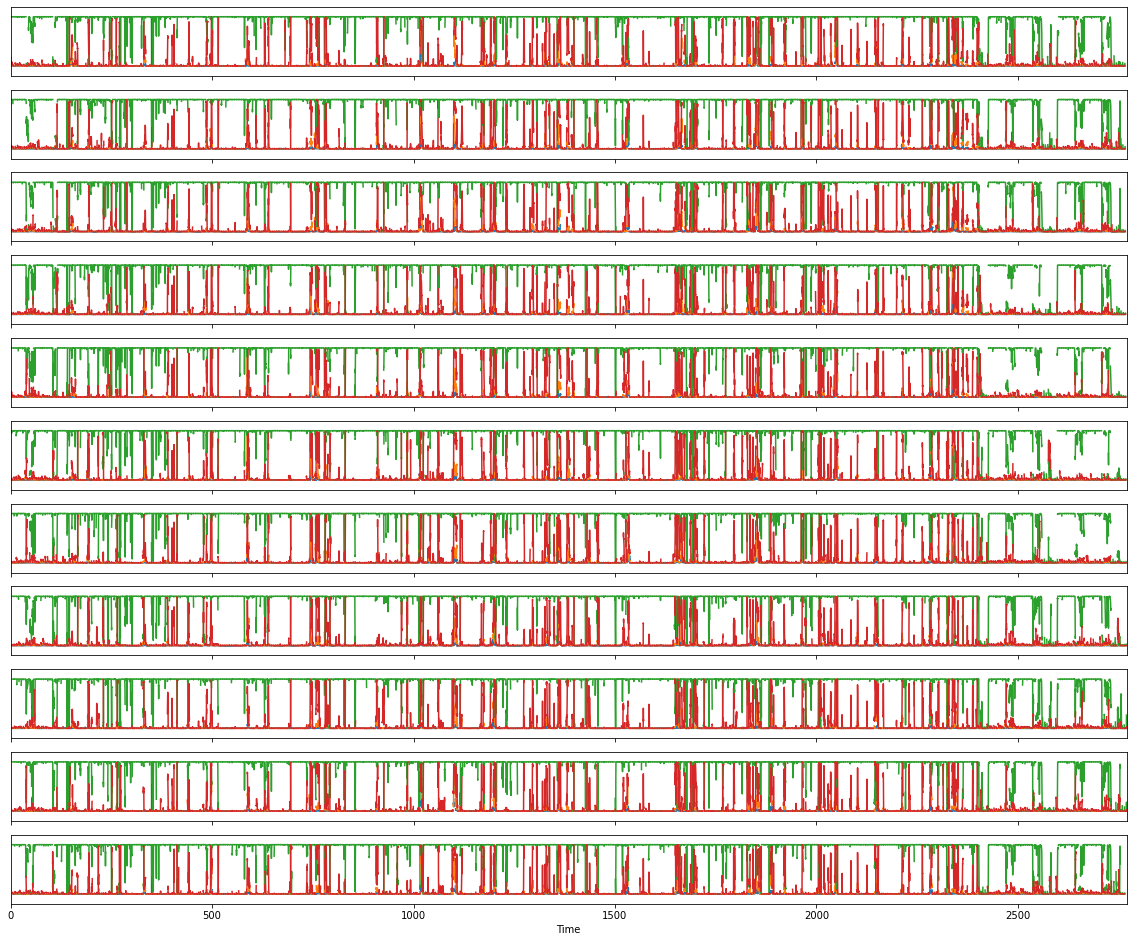

In [7]:
# применяю модель к аудио файлу

model = Inference('pyannote/segmentation')
segmentation = model(save_file)
segmentation

Для каждой из 11 позиций окна модель выводит 4-мерный вектор каждые 16 мс (293 кадра за 5 секунд), соответствующий вероятности того, что каждый из 4 динамиков активен.

<a name="dir_and_viz"></a>
## Диаризация речи
[К началу](#top)

Запуск визуализации процесса диаризации аудио

In [8]:
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization")
dia = pipeline(save_file)

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129k [00:00<?, ?B/s]

Использую API для записи результатов в dataframe в следующем формате:
`|  speaker  |  speech_start  |  speech_end  |`

In [9]:
# функция для записи timestamp в датафрейм

def wav_to_df(save_file):
  df = pd.DataFrame(columns=['speaker', 'speech_start', 'speech_end'])
  for speech_turn, track, speaker in dia.itertracks(yield_label=True):
    df.loc[len(df)] = [speaker, round(speech_turn.start,3), round(speech_turn.end,3)]
    df.to_csv('speak')
  return df

In [10]:
wav_to_df(mp4_to_wav(open_file, save_file))

,speaker,speech_start,speech_end
0,SPEAKER_00,0.258,38.480
1,SPEAKER_00,39.273,40.724
2,SPEAKER_00,42.715,48.689
3,SPEAKER_00,49.651,54.595
4,SPEAKER_00,55.490,59.725
...,...,...,...
185,SPEAKER_00,2643.271,2658.712
186,SPEAKER_00,2659.505,2708.628
187,SPEAKER_00,2712.712,2722.162
188,SPEAKER_00,2722.617,2724.929


<a name="vad"></a>
## Детекция голосовой активности
[К началу](#top)

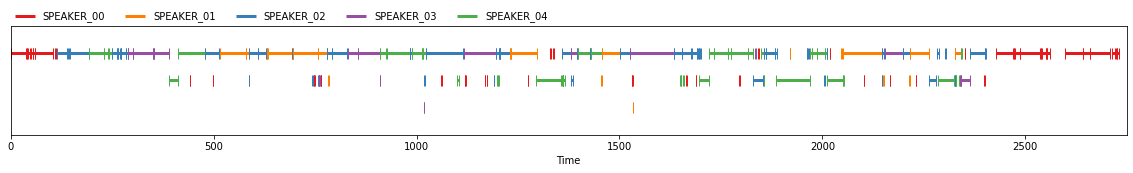

In [11]:
# визуализирую аудио файл

notebook.crop = Segment(0, 2750)
dia

На графике выше вся звуковая дорожка разделена на спикеров, также видно голосовую активность и паузы

Также можно визуализировать файл, представленный в виде словаря

In [12]:
waveform, sample_rate = torchaudio.load(save_file)

print(f"type(waveform)={type(waveform)}")
print(f"waveform.shape={waveform.shape}")
print(f"waveform.dtype={waveform.dtype}")

audio_in_memory = {"waveform": waveform, "sample_rate": sample_rate}

type(waveform)=<class 'torch.Tensor'>
waveform.shape=torch.Size([2, 122160128])
waveform.dtype=torch.float32


Downloading:   0%|          | 0.00/261 [00:00<?, ?B/s]

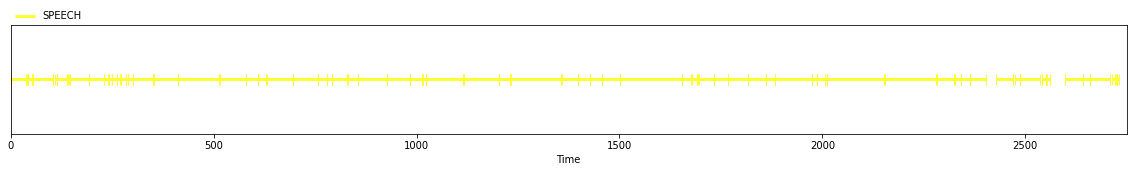

In [13]:
vad = Pipeline.from_pretrained("pyannote/voice-activity-detection")
vad(audio_in_memory)

График объединил всех спикеров в один speech и видно, когда люди говорили, а когда были паузы

<a name="speech_to_text"></a>
## Распознавание речи
[К началу](#top)

In [17]:
# загружаю модель для расстановки пунктуации в распознанном тексте

punct_model, _, _, _, apply_text = torch.hub.load(repo_or_dir='snakers4/silero-models', model='silero_te')

Downloading: "https://github.com/snakers4/silero-models/archive/master.zip" to /root/.cache/torch/hub/master.zip


  0%|          | 0.00/87.5M [00:00<?, ?B/s]

In [14]:
# функция для распознавания и записи в датафрейм соответствующего каждому спикеру текста + пунктуация

def speech_to_text(save_file):
    df = pd.read_csv('speak', index_col=0)
    df['text'] = df.apply(lambda _: '', axis=1)

    r = sr.Recognizer()
    i=0

    for i, row in df.iterrows():
        with sr.AudioFile(save_file) as source:

        # слушаю данные (загрузка аудио в память) с speech_start до speech_end
            audio_data = r.record(source, offset=df['speech_start'][i], duration=df['speech_end'][i] - df['speech_start'][i])
      
        # распознавание Google api (преобразование речи в текст)
        try:
            text = r.recognize_google(audio_data, language='ru')
            # обрабатываю полученный текст
            hypothesis = ' '.join(re.findall('[а-я|a-z]+', text.lower()))

            # пунктуация
            df['text'][i] = apply_text(hypothesis, lan='ru')
            i+=1
        except sr.UnknownValueError:
            df['text'][i] = ' '
    
    # сохранение в файл
    df.to_csv('speak')
    return df

In [18]:
speech_to_text(mp4_to_wav(open_file, save_file))

,speaker,speech_start,speech_end,text
0,SPEAKER_00,0.258,38.480,
1,SPEAKER_00,39.273,40.724,
2,SPEAKER_00,42.715,48.689,
3,SPEAKER_00,49.651,54.595,
4,SPEAKER_00,55.490,59.725,
...,...,...,...,...
185,SPEAKER_00,2643.271,2658.712,
186,SPEAKER_00,2659.505,2708.628,
187,SPEAKER_00,2712.712,2722.162,
188,SPEAKER_00,2722.617,2724.929,


In [19]:
# в отдельный столбец записываю время между началом и концом речи

df = pd.read_csv('speak', index_col=0)
df['sum_time'] = df['speech_end']-df['speech_start']
df

,speaker,speech_start,speech_end,text,sum_time
0,SPEAKER_00,0.258,38.480,,38.222
1,SPEAKER_00,39.273,40.724,,1.451
2,SPEAKER_00,42.715,48.689,,5.974
3,SPEAKER_00,49.651,54.595,,4.944
4,SPEAKER_00,55.490,59.725,,4.235
...,...,...,...,...,...
185,SPEAKER_00,2643.271,2658.712,,15.441
186,SPEAKER_00,2659.505,2708.628,,49.123
187,SPEAKER_00,2712.712,2722.162,,9.450
188,SPEAKER_00,2722.617,2724.929,,2.312


In [20]:
# суммарное время речи каждого спикера

df.groupby("speaker")['sum_time'].sum()

speaker
SPEAKER_00    376.951
SPEAKER_01    497.711
SPEAKER_02    644.540
SPEAKER_03    455.033
SPEAKER_04    728.562
Name: sum_time, dtype: float64

In [21]:
# общий текст каждого спикера

df.groupby("speaker")['text'].sum()

speaker
SPEAKER_00                    Уже на тему      Вот это же це...
SPEAKER_01    А мне кажется, что студенты ценит открытость о...
SPEAKER_02    Всем привет меня зовут Андрей тексты ты смотри...
SPEAKER_03     Здесь вс сообщества нашего университета это д...
SPEAKER_04    Да а я думал, что-то кстати я не самый мучител...
Name: text, dtype: object

In [22]:
# объединяю весь текст для последующей оценки качества

def str_append(n):
    output = ''
    i = 0
    while i < n:
        output += df['text'][i]
        i += 1
    return output

In [23]:
all_text = str_append(len(df))
hypothesis = ' '.join(re.findall('[а-я|a-z]+', all_text.lower()))
hypothesis = re.sub(r'[^\w\s]','', hypothesis)
hypothesis

'всем привет меня зовут андрей тексты ты смотришь если на нтв нас уже второй выпуск на подходе надеюсь тебе уютно и комфортно в телеграм канале чеки прямо сейчас ставь какую нибудь классную эмодзи в связи с этим ну а я готов тебе сообщить что мы нашли самых классных ответчиков на те вопросы которые ты часто зада шь дорогой наш зритель разреши тебе представить первый проректор университета итмо дарья константиновна козлов начальник управления качества образовательного процесса ольга елисеева ну и конечно же директор тут офиса университет итмо елена борисова конечно же запомните пожалуйста лица этих прекрасных девушек потому что это ну мне кажется главное главное женские лица которые будут помогать вам в течение всего вашего учебного процесса не вылететь остаться на плаву но и в целом вести себя классно круто и комфортно в университете с чего начн м начн м с самого главного вопроса который мучает очень много кого не только студентов университета итмо но и студентов других каких то вузов 

In [24]:
all_text

'       Всем привет меня зовут Андрей тексты ты смотришь если на нтв нас уже второй выпуск на подходе надеюсь тебе уютно и комфортно в телеграм канале чеки прямо сейчас ставь какую нибудь классную эмодзи. В связи с этим ну а я готов тебе сообщить, что мы нашли самых классных ответчиков на те вопросы, которые ты часто зада шь дорогой наш зритель разреши тебе представить первый проректор университета итмо Дарья Константиновна Козлов.Начальник управления качества образовательного процесса Ольга Елисеева.Ну и конечно, же директор тут офиса университет итмо Елена Борисова. Конечно же запомните пожалуйста лица этих прекрасных девушек. Потому что это ну мне кажется главное главное женские лица, которые будут помогать вам в течение всего вашего учебного процесса не вылететь остаться на плаву но и в целом вести себя классно круто и комфортно в университете с чего начн м начн м с самого главного вопроса, который мучает очень много кого не только студентов университета итмо, но и студентов других

<a name="entity"></a>
## Извлечение именованных сущностей
[К началу](#top)

Для извлечения именнованных сущностей использую модель Stanza Стэнфордского университета и PullEnti wrapper для русского языка. на данном этапе найду сущности класа `PERSON`.

In [26]:
stanza.download('ru')
def stanza_nlp_ru(text):
    nlp = stanza.Pipeline(lang='ru', processors='tokenize,ner')
    doc = nlp(text)
    for sent in doc.sentences:
      for ent in sent.ents:
        if ent.type == 'PER':
          print(*[f'entity: {ent.text}\ttype: {ent.type}'], sep='\n')
stanza_nlp_ru(all_text)

2022-06-27 09:57:09 INFO: Downloading default packages for language: ru (Russian)...


2022-06-27 09:57:29 INFO: Finished downloading models and saved to /root/stanza_resources.


2022-06-27 09:57:31 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| ner       | wikiner   |

2022-06-27 09:57:31 INFO: Use device: gpu
2022-06-27 09:57:31 INFO: Loading: tokenize
2022-06-27 09:57:31 INFO: Loading: ner
2022-06-27 09:57:32 INFO: Done loading processors!


entity: Андрей	type: PER
entity: Дарья Константиновна Козлов.	type: PER
entity: Ольга Елисеева.Ну	type: PER
entity: Елена Борисова	type: PER
entity: Ольге	type: PER
entity: Скилл	type: PER
entity: Форсайт	type: PER
entity: Веке	type: PER
entity: Оля	type: PER
entity: Бер	type: PER
entity: Бер	type: PER
entity: Skillbox	type: PER
entity: Бер	type: PER
entity: Супер Елена	type: PER
entity: Анна Снежина	type: PER
entity: Елена	type: PER
entity: Бэтмен	type: PER
entity: Гром	type: PER
entity: Коворкинг	type: PER
entity: Иногда	type: PER
entity: По	type: PER
entity: Вот	type: PER
entity: Константин О кей	type: PER
entity: Елена	type: PER
entity: Лены	type: PER
entity: Елена	type: PER
entity: Елена	type: PER
entity: Ольга	type: PER
entity: Да	type: PER
entity: Я	type: PER
entity: Елена	type: PER
entity: Мы	type: PER
entity: ZaraЗаранее	type: PER
entity: Ольга Елисеева	type: PER
entity: Елена Борисова	type: PER


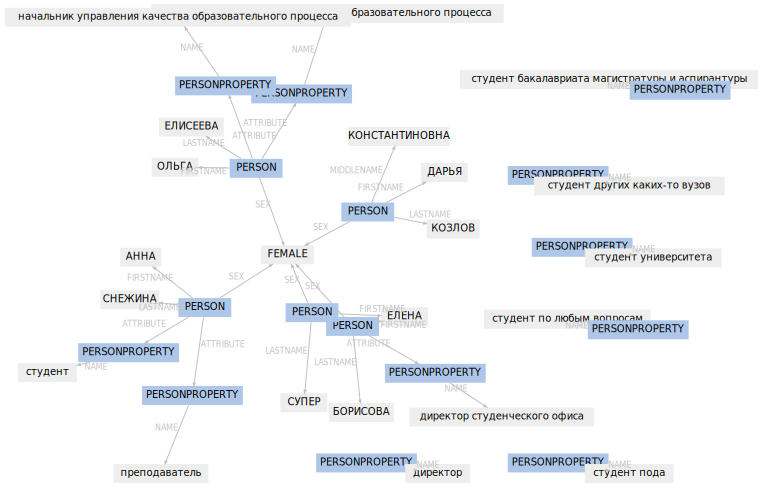

In [38]:
processor = Processor([PERSON])
result = processor(all_text)
result.graph

**Вывод:** Обе модели хорошо выделяю сущности, но Stanza находит лишнее, а PullEnti wrapper хорошо находит взаимосвязи между частями имени `PERSON` и `PERSONPROPETY`.

<a name="quality"></a>
## Оценка качества
[К началу](#top)

In [29]:
# функция для открытия и чтения оригинального текста речи

def read_orig(filepath):
    orig = open(filepath, 'r', encoding='utf8')
    ref = orig.read()
    ref = re.sub("\n", ' ', ref)

    # обрабатываю полученный текст
    truth = ' '.join(re.findall('[а-я|a-z]+', ref.lower()))
    return truth

In [30]:
# функция для записи в датафрейм метрик качества

def show_metrics(truth, hypothesis):
    metrics = compute_measures(truth, hypothesis)
    df = pd.DataFrame(columns=['Truth', 'Hypothesis', 'WER', 'MER', 'WIL', 'WIP', 'Hits', 'Substitutions', 'Deletions', 'Insertions'])
    df.loc[len(df)] = [truth, hypothesis, round(metrics['wer'],4), round(metrics['mer'],4), round(metrics['wil'],4), round(metrics['wip'],4), metrics['hits'], metrics['substitutions'], metrics['deletions'], metrics['insertions']]
    df.to_csv('quality')
    return df

### Метрики оценки качества
* **WER** (word error rate), измеряет показывает, насколько распознанный текст отличается от оригинала.
* **MER** (match error rate) это доля совпадений слов ввода-вывода, которые являются ошибками.
* **WIL** (word information lost) это простое приближение к доле потерянной словесной информации.
* **Hits** это совпадения слов между оригинальным и распознанным текстом.
* **Substitutions** это слова, которые были заменены в распознанном тексте.
* **Deletions** это слова, которые были удалены в распознаном тексте.
* **Insertions** это слова, которые были добавлены в распознаном тексте.

In [31]:
show_metrics(read_orig(path+'//ITMO_ENTER.txt'), hypothesis)

,Truth,Hypothesis,WER,MER,WIL,WIP,Hits,Substitutions,Deletions,Insertions
0,всем привет меня зовут андрей кияк и ты смотри...,всем привет меня зовут андрей тексты ты смотри...,0.2876,0.2794,0.4224,0.5776,4001,979,413,159


**Вывод:** Результаты оценки качества показывают, что распознаный текст в сравнении с state of the art решением данной задачи похож на 77%. 4 тыс. слов распознаны верно из 5.5 тыс. слов.

Также стоит отметить, что система выделила в отдельного спикера заставку и окончание видео, из-за того что в это время играла мелодия, но у данного спикера не распознана речь.